In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_8 共1个任务  健康：骨肉瘤肺转移：骨肉瘤未转移= 36：56：50

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data8/peaks.csv', t = True)
Y = np.zeros((142,3))                                             #将标签以独热编码存起来142
for i in range (0,36):                                           #H 36例
    Y[i,0] = 1                                                    
for i in range (36,92):                                          #L 56例
    Y[i,1] = 1                                                   
for i in range (92,142):                                         #NL 50例
    Y[i,2] = 1                                                   
y = Y.astype(int)
Y = np.zeros(142)                                                #用于分层的标签
for i in range (0,36):                                           #H 36例
    Y[i] = 0                                                    
for i in range (36,92):                                          #L 56例
    Y[i] = 1                                                   
for i in range (92,142):                                         #NL 50例
    Y[i] = 2 
Y = Y.astype(int)

In [8]:
dfx

,2208.0,2216.0,2225.0,2227.0,2238.0,2247.0,2249.0,2259.0,2269.0,2272.0,...,6443.0,6641.0,6685.0,6768.0,6970.0,6993.0,7626.0,7945.0,8612.0,8943.0
0,2.374906,4.264514,3.027746,2.021240,2.346486,1.438073,5.109197,2.420660,6.413190,5.079065,...,3.093940,2.397209,2.278436,0.806902,0.256742,1.478951,3.315899,0.465027,0.462932,2.253575
1,1.586887,3.343985,1.898540,0.890767,7.005771,5.238413,3.164339,5.339230,5.500146,6.478841,...,0.073618,3.886400,4.647211,1.335185,1.805491,1.409422,5.254517,2.287986,4.078729,1.567520
2,2.215919,3.712327,3.588721,3.032524,4.736695,3.143461,5.708686,5.610888,4.778993,4.780972,...,1.668254,2.787894,1.557031,0.818632,3.551865,2.177890,7.107766,1.760850,0.620606,2.362909
3,1.561481,2.927603,4.224639,4.921712,5.529260,2.332047,4.897834,4.947587,3.159059,1.646745,...,3.354092,2.798721,2.400270,2.436804,3.908383,1.452407,8.843560,5.559745,0.827735,0.973606
4,3.658209,4.466523,3.715490,5.718252,5.003395,4.520780,4.720882,4.171102,6.477026,5.353912,...,4.057702,2.230162,2.373647,1.768109,2.895810,1.883490,4.266529,8.658395,0.850413,0.830646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,5.149613,1.021660,12.367983,13.307593,7.747415,11.175052,12.308735,1.416052,6.244122,7.800350,...,0.859947,4.509434,9.350139,10.990928,9.378284,15.068692,2.023644,1.597739,2.960428,0.410254
138,0.603752,7.137119,9.789531,6.588657,6.991312,8.089764,7.001896,0.505007,5.791170,3.573749,...,4.838269,2.849689,5.160426,5.731947,6.862079,12.655783,1.980870,2.604762,2.400120,2.623661
139,1.140033,6.931005,12.879026,7.219526,6.114812,13.258256,9.557385,1.361930,9.113288,7.241417,...,4.195835,2.735596,4.935091,6.881160,10.018234,12.600659,2.575731,3.427110,1.952226,5.030157
140,0.553815,10.113647,9.430793,4.121029,17.213266,9.065296,5.005007,3.149287,6.691718,5.762540,...,4.645874,0.319732,4.647387,5.650880,12.108153,11.746351,2.303853,11.149419,2.773087,3.728802


In [9]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data8', file_type = 'aggmap', file_name = 'aggmap_peaks.mp')

2024-01-02 14:36:03,449 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 14:36:03,462 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 286/286 [00:00<00:00, 561.93it/s]


2024-01-02 14:36:06,241 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 14:36:10,272 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 14:36:10,357 - INFO - [bidd-aggmap] - Finished


In [5]:
mp = load('/mnt/lzyt/SmallSamples/data8/aggmap/aggmap_peaks.mp')

In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 142/142 [00:04<00:00, 34.84it/s] 


y_pred is  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_real is  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


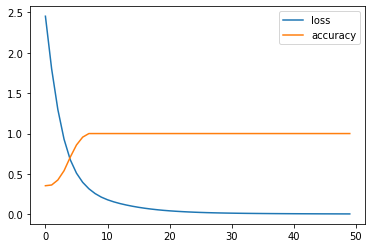

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_real is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


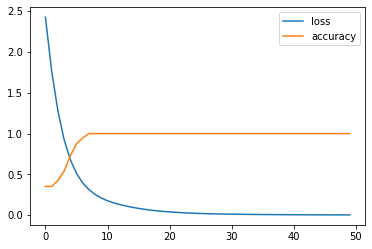

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_real is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


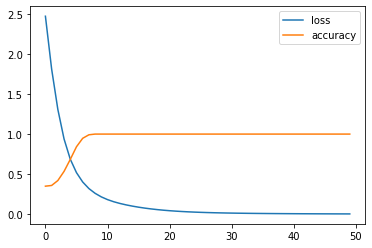

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_real is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Acc =  0.9642857142857143
f1_score =  0.9642857142857143
average_precision =  0.9642857142857143
recall_score =  0.9642857142857143


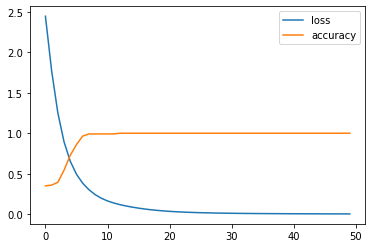

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_real is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


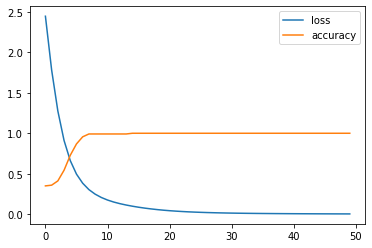

0.9928571428571429

In [12]:
#三核 四折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64],batch_size=128,epochs=50,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    print('y_pred is ',y_pred)
    print('y_real is ',test_y)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

y_pred is  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_true is  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Auc is  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


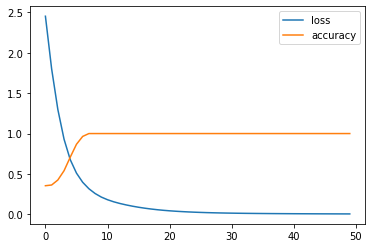

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_true is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Auc is  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


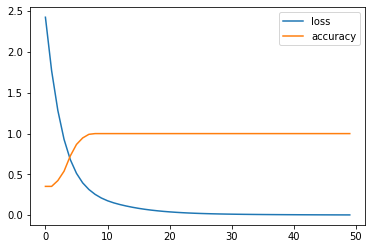

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_true is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Auc is  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


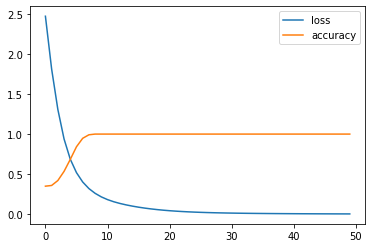

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_true is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Auc is  0.9963656169538523
Acc =  0.9642857142857143
f1_score =  0.9642857142857143
average_precision =  0.9642857142857143
recall_score =  0.9642857142857143


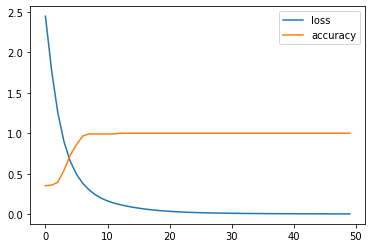

y_pred is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
y_true is  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Auc is  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


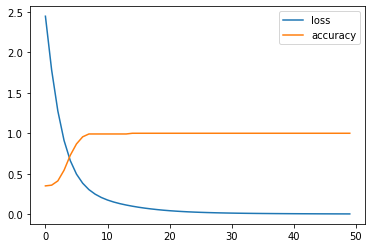

0.9928571428571429

In [11]:
#三核 四折交叉验证最佳结果带AUC
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64],batch_size=128,epochs=50,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    y_prob = clf.predict_probs(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_prob,multi_class='ovr')
    print('y_pred is ',y_pred)
    print('y_true is ',test_y)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc is ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5